In [35]:
from typing import Callable, Iterator, Sequence, Tuple
import functools

import numpy as np
import scipy as sp
import matplotlib.pylab as plt

import jax.numpy as jnp
import jax.scipy as jsp
import jax
import flax.linen as nn
import optax
import haiku as hk
import chex
import tqdm

In [36]:
def generate_checkerboard(*, num: int, rng: np.random.Generator) -> np.ndarray:
    # https://github.com/malbergo/stochastic-interpolants/blob/main/notebooks/checker-mirror.ipynb
    x1 = rng.uniform(size=num) * 4 - 2
    x2_ = rng.uniform(size=num) - rng.choice([0, 1], size=(num,)) * 2
    x2 = x2_ + (np.floor(x1) % 2)
    x = np.hstack([x1[:, None], x2[:, None]]) * 2
    return x

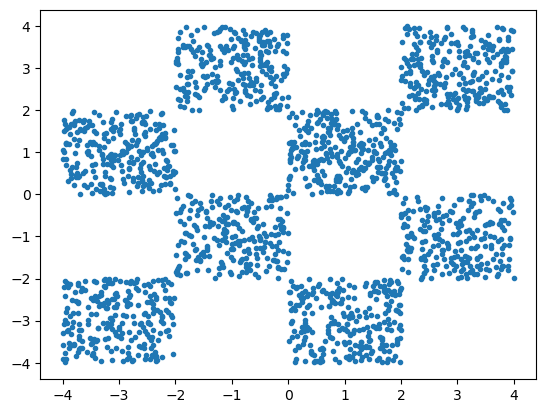

In [37]:
X_train = generate_checkerboard(num=2000, rng=np.random.default_rng())
plt.plot(X_train[:, 0], X_train[:, 1], '.')

In [43]:
Activation = Callable[[jax.numpy.ndarray], jax.numpy.ndarray]

class DiffusionMLP(nn.Module):
    features: Sequence[int]
    activation: Activation = nn.relu

    @nn.compact
    def __call__(self, x: jax.numpy.ndarray, train: bool = False) -> jax.numpy.ndarray:
        # The train parameter is accepted but not used since there's no specific behavior like dropout.
        for f in self.features[:-1]:
            x = nn.Dense(f)(x)
            x = self.activation(x)
        
        # Assuming the output layer predicts eps parameters (noise)
        eps = nn.Dense(x.shape[-1])(x)
        
        return eps
    
model = DiffusionMLP(features=[64, 64, 64])
print(model.tabulate(jax.random.PRNGKey(0), jnp.zeros((1, 2))))



                              DiffusionMLP Summary                              
┏━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module       ┃ inputs        ┃ outputs       ┃ params              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│         │ DiffusionMLP │ float32[1,2]  │ float32[1,64] │                     │
├─────────┼──────────────┼───────────────┼───────────────┼─────────────────────┤
│ Dense_0 │ Dense        │ float32[1,2]  │ float32[1,64] │ bias: float32[64]   │
│         │              │               │               │ kernel:             │
│         │              │               │               │ float32[2,64]       │
│         │              │               │               │                     │
│         │              │               │               │ 192 (768 B)         │
├─────────┼──────────────┼───────────────┼───────────────┼─────────────────────┤
│ Dense_1 │ Dense        │ 

In [41]:
from typing import Any, Generator, Union


Array = jax.numpy.ndarray
Params = optax.Params
Config = Any

class Diffuser:
    def __init__(self, eps_fn: Callable[[Params, Array, int, bool], Array], config: Config):
        self.eps_fn = eps_fn
        self.betas = jnp.asarray(self._compute_betas(config['beta_1'], config['beta_T'], config['T']))
        self.alphas = 1 - self.betas
        self.alpha_bars = jnp.cumprod(self.alphas)

    @functools.partial(jax.jit, static_argnums=(0,))
    def forward(self, x_0: Array, rng: jax.random.PRNGKey) -> Tuple[Array, Array, Array]:
        rng1, rng2 = jax.random.split(rng)
        t = jax.random.randint(rng1, (len(x_0), 1), 0, len(self.betas))
        x_t, eps = self.sample_q(x_0, t, rng2)
        return x_t, t, eps

    def sample_q(self, x_0: Array, t: Array, rng: jax.random.PRNGKey) -> Tuple[Array, Array]:
        alpha_t_bar = self.alpha_bars[t.flatten()]
        eps = jax.random.normal(rng, shape=x_0.shape, dtype=x_0.dtype)
        x_t = (alpha_t_bar**0.5) * x_0 + ((1 - alpha_t_bar) ** 0.5) * eps
        return x_t, eps

    @functools.partial(jax.jit, static_argnums=(0,))
    def ddpm_backward_step(self, params: Params, x_t: Array, t: int, rng: jax.random.PRNGKey) -> Array:
        alpha_t = self.alphas[t]
        alpha_t_bar = self.alpha_bars[t]
        sigma_t = self.betas[t] ** 0.5
        z = jax.random.normal(rng, shape=x_t.shape, dtype=x_t.dtype)
        eps = self.eps_fn(params, x_t, t, train=False)
        x = (1 / alpha_t**0.5) * (x_t - ((1 - alpha_t) / alpha_t_bar**0.5) * eps) + sigma_t * z
        return x

    def ddpm_backward(self, params: Params, x_T: Array, rng: jax.random.PRNGKey) -> Array:
        x = x_T
        for t in reversed(range(len(self.betas))):
            rng, rng_ = jax.random.split(rng)
            x = self.ddpm_backward_step(params, x, t, rng_)
        return x

    def _compute_betas(self, beta_1: float, beta_T: float, T: int) -> Array:
        return jnp.linspace(beta_1, beta_T, T, dtype=jnp.float32)

In [44]:

# 初始化模型和优化器
model = DiffusionMLP(features=[64, 64, 64])
params = model.init(jax.random.PRNGKey(0), jnp.zeros((1, 10)))  # 假设输入维度为10
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)

# 初始化Diffuser
diffuser = Diffuser(eps_fn=model.apply, config={'beta_1': 0.1, 'beta_T': 0.2, 'T': 1000})

# 训练循环
@jax.jit
def train_step(rng, params, opt_state, x_0):
    rng, rng1, rng2 = jax.random.split(rng, 3)
    x_t, t, _ = diffuser.forward(x_0, rng1)  # 前向扩散
    reconstructed_x_0 = diffuser.ddpm_backward(params, x_t, rng2)  # 反向恢复
    loss = jnp.mean((x_0 - reconstructed_x_0) ** 2)  # 计算损失

    grads = jax.grad(loss)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

# 模拟数据和训练
rng = jax.random.PRNGKey(0)
losses = []
for _ in tqdm.tqdm(range(1000)):  # 迭代次数
    rng, key = jax.random.split(rng)
    x_0 = jax.random.normal(key, (10,))  # 随机生成训练数据
    loss, params, opt_state = train_step(rng, params, opt_state, x_0)
    losses.append(loss)

losses = np.array(losses)

  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: DiffusionMLP.__call__() got multiple values for argument 'train'

In [ ]:
plt.plot(losses)